## VAEs on MNIST

#### Imports

In [10]:
import os

import torch
import torch.nn as nn
import torch.utils.data as tdata
import torchvision
import torchvision.transforms as T

import vaes_ptorch.args as args
import vaes_ptorch.models as models
import vaes_ptorch.proba as proba
import vaes_ptorch.train_vae as train_vae
import vaes_ptorch.vae as vae_nn
import vaes_ptorch.utils as ut

#### Experiment parameters

In [2]:
use_gpu = True

latent_dim = 2

lr = 1e-3
batch_size = 128
num_epochs = 10

print_every = 0
eval_every = 5

# info_vae = True
info_vae = False
start_scale = 0
end_scale = 0
# start_scale = 500.0
# end_scale = 500.0
start_epochs = 0
linear_epochs = 0

in_channels = 1

device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"
device

'cpu'

#### Getting the training data

In [3]:
def binarize(x):
    """Converts grayscale pixel values in [0, 1] to binary data in {0, 1}."""
    tensor = T.ToTensor()(x)
    mask = tensor > 0.5
    tensor[mask] = 1.0
    tensor[~mask] = 0.0
    return tensor


dataset = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=True,
    download=True,
    transform=binarize,
)

train_size = int(len(dataset) * 0.7)
eval_size = len(dataset) - train_size
train_data, eval_data = tdata.random_split(
    dataset,
    [train_size, eval_size],
    generator=torch.Generator().manual_seed(15),
)

train_loader = tdata.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True
)
eval_loader = tdata.DataLoader(
    dataset=eval_data, batch_size=batch_size, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root=os.path.expanduser("~/vaes_ptorch/data"),
    train=False,
    download=True,
    transform=binarize,
)
test_loader = tdata.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=True
)

### COMMENT OUT THE BELOW 2 LINES FOR ACTUAL EVALUATION
# test_loader = train_loader
# eval_loader = train_loader
print(f"Train size: {train_size}, Eval size: {eval_size}")

Train size: 42000, Eval size: 18000


/home/arnaud15/miniconda3/envs/ptorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630778054/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Setting up the VAE model

In [4]:
encoder = models.GaussianNN(
    model=nn.Sequential(
        nn.Flatten(),
        models.get_mlp(
            in_dim=28 * 28, out_dim=2 * latent_dim, h_dims=[512] * 3
        ),
    ),
    out_dim=latent_dim,
    min_var=1e-10,
)
decoder = nn.Sequential(
    models.get_mlp(in_dim=latent_dim, out_dim=1 * 28 * 28, h_dims=[512] * 3),
    nn.Unflatten(1, (1, 28, 28)),
)
vae = vae_nn.GaussianVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    stats_model=proba.BernoulliModel(),
)
vae = vae.to(device)

#### Initializing the optimizer and training arguments

In [5]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)

train_args = args.TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=args.DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    eval_every=eval_every,
    smoothing=0.9,
)

### Training

In [6]:
train_vae.train(
    train_data=train_loader,
    vae=vae,
    optimizer=optimizer,
    train_args=train_args,
    eval_data=eval_loader,
    device=device,
)

ELBO at the end of epoch #1 is 0.00001
ELBO at the end of epoch #6 is 0.00001


Results(train_ewma=141.33522543164563, eval_ewma=1.0000000000000021e-05)

In [7]:
evaluate(test_loader, vae, args=train_args, device=device)

NameError: name 'evaluate' is not defined

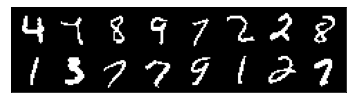

In [11]:
x, y = next(iter(test_loader))
input_images = x.to(device)
ut.show(input_images[:16])

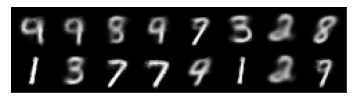

In [12]:
reconstructed_images = nn.Sigmoid()(vae(input_images).x_params)
ut.show(reconstructed_images[:16])

In [13]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2, whiten=True)

X_data = vae(input_images).z_params.mu.detach().cpu().numpy()
print(X_data.shape)
labels = y.detach().numpy()
print(labels.shape)

(128, 2)
(128,)


In [14]:
projected_data = pca_model.fit_transform(X_data)
print(f"PCA quality check: {pca_model.explained_variance_ratio_}")
projected_data.shape

PCA quality check: [0.79158527 0.20841478]


(128, 2)

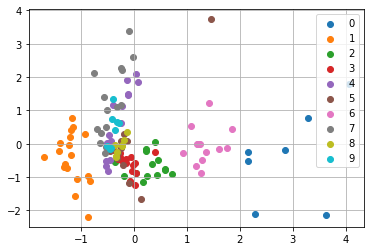

In [15]:
import matplotlib.pyplot as plt

all_labels = set(labels)
plt.figure()
for label in all_labels:
    label_mask = labels == label
    label_data = projected_data[label_mask, :]
    plt.scatter(label_data[:, 0], label_data[:, 1], label=str(label))
plt.grid()
plt.legend()
plt.show()
plt.close()